Implementation of stochastic and batch grandient descent in python
We will use very simple home prices data set to implement batch and stochastic gradient descent in python. Batch gradient descent uses all training samples in forward pass to calculate cumulitive error and than we adjust weights using derivaties. In stochastic GD, we randomly pick one training sample, perform forward pass, compute the error and immidiately adjust weights. So the key difference here is that to adjust weights batch GD will use all training samples where as stochastic GD will use one randomly picked training sample

In [39]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [40]:
df = pd.read_csv('homeprices_banglore.csv')
df.sample(5)

,area,bedrooms,price
15,1175,2,42.0
10,1800,3,82.0
3,1521,3,75.0
17,1540,3,60.0
12,1000,2,38.0



Preprocessing/Scaling: Since our columns are on different sacle it is important to perform scaling on them

In [41]:
from sklearn import preprocessing
sx = preprocessing.MinMaxScaler()
sy = preprocessing.MinMaxScaler()

scaled_X = sx.fit_transform(df.drop('price', axis='columns'))
scaled_y = sy.fit_transform(df['price'].values.reshape(df.shape[0], 1))

scaled_X[:5]

array([[0.08827586, 0.25      ],
       [0.62068966, 0.75      ],
       [0.22068966, 0.5       ],
       [0.24862069, 0.5       ],
       [0.13793103, 0.25      ]])

In [45]:
scaled_y[:5]

array([[0.05237037],
       [0.65185185],
       [0.22222222],
       [0.31851852],
       [0.14074074]])

We should convert target column (i.e. price) into one dimensional array. It has become 2D due to scaling that we did above but now we should change to 1D

In [46]:
scaled_y.reshape(20,)

array([0.05237037, 0.65185185, 0.22222222, 0.31851852, 0.14074074,
       0.04444444, 0.76296296, 0.91111111, 0.13333333, 1.        ,
       0.37037037, 0.8       , 0.04444444, 0.05925926, 0.51111111,
       0.07407407, 0.11851852, 0.20740741, 0.51851852, 0.        ])

Gradient descent allows you to find weights (w1,w2,w3) and bias in following linear equation for housing price prediction

Now is the time to implement mini batch gradient descent.

In [48]:
def batch_gradient_descent(X, y_true, epochs, learning_rate = 0.01):

    number_of_features = X.shape[1]
    # numpy array with 1 row and columns equal to number of features. In 
    # our case number_of_features = 2 (area, bedroom)
    w = np.ones(shape=(number_of_features)) 
    b = 0
    total_samples = X.shape[0] # number of rows in X
    
    cost_list = []
    epoch_list = []
    
    for i in range(epochs):        
        y_predicted = np.dot(w, X.T) + b

        w_grad = -(2/total_samples)*(X.T.dot(y_true-y_predicted))
        b_grad = -(2/total_samples)*np.sum(y_true-y_predicted)
        
        w = w - learning_rate * w_grad
        b = b - learning_rate * b_grad
        
        cost = np.mean(np.square(y_true-y_predicted)) # MSE (Mean Squared Error)
        
        if i%10==0:
            cost_list.append(cost)
            epoch_list.append(i)
        
    return w, b, cost, cost_list, epoch_list

w, b, cost, cost_list, epoch_list = batch_gradient_descent(scaled_X,scaled_y.reshape(scaled_y.shape[0],),500)
w, b, cost


(array([0.70712464, 0.67456527]), -0.23034857438407427, 0.0068641890429808105)

Check price equation above. In that equation we were trying to find values of w1,w2 and bias. Here we got these values for each of them,
w1 = 0.66469087 w2 = 0.60541671 bias = -0.17792104056392882

Now plot epoch vs cost graph to see how cost reduces as number of epoch increases

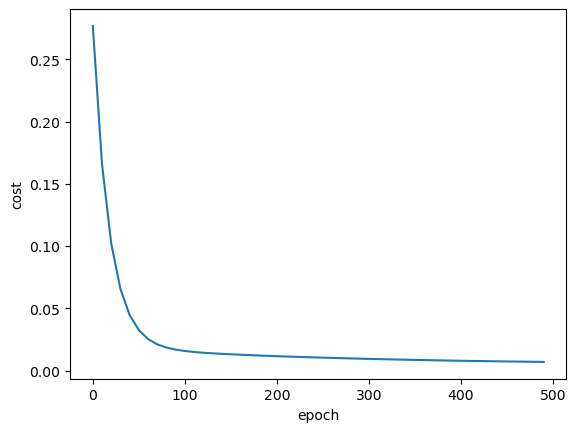

In [49]:
plt.xlabel("epoch")
plt.ylabel("cost")
plt.plot(epoch_list,cost_list)

Lets do some predictions now.

In [50]:

def predict(area,bedrooms,w,b):
    scaled_X = sx.transform([[area, bedrooms]])[0]
    # here w1 = w[0] , w2 = w[1], w3 = w[2] and bias is b
    # equation for price is w1*area + w2*bedrooms + w3*age + bias
    # scaled_X[0] is area
    # scaled_X[1] is bedrooms
    # scaled_X[2] is age
    scaled_price = w[0] * scaled_X[0] + w[1] * scaled_X[1] + b
    # once we get price prediction we need to to rescal it back to original value
    # also since it returns 2D array, to get single value we need to do value[0][0]
    return sy.inverse_transform([[scaled_price]])[0][0]

predict(2600,4,w,b)

/orange/alberto.perezant/imesh.ranaweera/.conda/envs/ml/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


128.45484403267596

In [51]:
predict(1000,2,w,b)

/orange/alberto.perezant/imesh.ranaweera/.conda/envs/ml/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


30.253094462442355

In [52]:
predict(1500,3,w,b)

/orange/alberto.perezant/imesh.ranaweera/.conda/envs/ml/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


69.47860785714694

(2) Stochastic Gradient Descent Implementation

Stochastic GD will use randomly picked single training sample to calculate error and using this error we backpropage to adjust weights

In [59]:
# we will use random libary to pick random training sample.
import random
random.randint(0,6) # randit gives random number between two numbers specified in the argument

5

In [63]:
def stochastic_gradient_descent(X, y_true, epochs, learning_rate = 0.01):
 
    number_of_features = X.shape[1]
    # numpy array with 1 row and columns equal to number of features. In 
    # our case number_of_features = 3 (area, bedroom and age)
    w = np.ones(shape=(number_of_features)) 
    b = 0
    total_samples = X.shape[0]
    
    cost_list = []
    epoch_list = []
    
    for i in range(epochs):    
        random_index = random.randint(0,total_samples-1) # random index from total samples
        sample_x = X[random_index]
        sample_y = y_true[random_index]
        
        y_predicted = np.dot(w, sample_x.T) + b
    
        w_grad = -(2/total_samples)*(sample_x.T.dot(sample_y-y_predicted))
        b_grad = -(2/total_samples)*(sample_y-y_predicted)
        
        w = w - learning_rate * w_grad
        b = b - learning_rate * b_grad
        
        cost = np.square(sample_y-y_predicted)
        
        if i%100==0: # at every 100th iteration record the cost and epoch value
            cost_list.append(cost)
            epoch_list.append(i)
        
    return w, b, cost, cost_list, epoch_list

w_sgd, b_sgd, cost_sgd, cost_list_sgd, epoch_list_sgd = stochastic_gradient_descent(scaled_X,scaled_y.reshape(scaled_y.shape[0],),10000)
w_sgd, b_sgd, cost_sgd

(array([0.7090924 , 0.67528125]), -0.2306546608639161, 0.00035704555657723846)

In [64]:
w , b

(array([0.70712464, 0.67456527]), -0.23034857438407427)

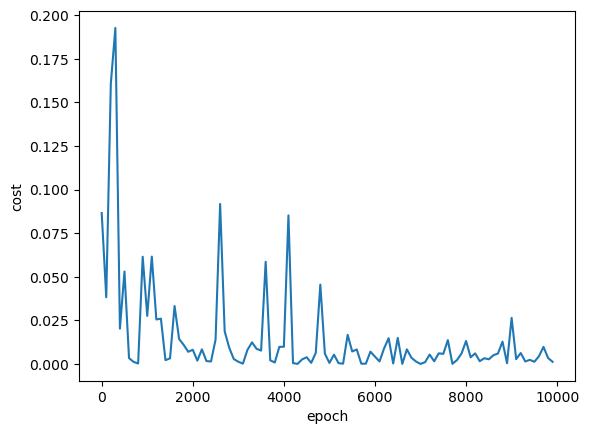

In [65]:
plt.xlabel("epoch")
plt.ylabel("cost")  
plt.plot(epoch_list_sgd,cost_list_sgd)

In [66]:
predict(2600,4,w_sgd, b_sgd)

/orange/alberto.perezant/imesh.ranaweera/.conda/envs/ml/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


128.65090080050206

In [67]:
predict(1000,2,w_sgd, b_sgd)

/orange/alberto.perezant/imesh.ranaweera/.conda/envs/ml/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


30.254257850137865

In [68]:
predict(1500,3,w_sgd, b_sgd)

/orange/alberto.perezant/imesh.ranaweera/.conda/envs/ml/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


69.54973712111219